# Kernel Fourier Networks
Friday Oct 2, 2020

- filter = Tensor(3x3)
- k = FFT(filter)
- K(... params) = approx(k)

- apply pointwise multiplication of approx(k) and FFT of image.


# Data

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

In [2]:
NUM_CLASSES = 2
IMG_SIZE=(150, 150)
def makeThumb(img, size=(150,150)):
  return tf.keras.preprocessing.image.smart_resize(img, size)/255.0

In [3]:
import tensorflow_datasets
cats_vs_dogs = tensorflow_datasets.image.cats_vs_dogs.CatsVsDogs()
cats_vs_dogs.download_and_prepare()
dataset = cats_vs_dogs.as_dataset(shuffle_files=False)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteGQ8AUG/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [4]:
def to_numpy(ds, size=None):
  X = []
  y = []
  csize=0
  for datapoint in ds:
    if size != None and csize > size:
      return X, y
    X.append(makeThumb(datapoint['image'].numpy(), size=IMG_SIZE))
    y.append(tf.keras.utils.to_categorical(datapoint['label'].numpy(), NUM_CLASSES))
    csize+=1
  return X, y

def to_gen(X, y, batch_size=32):
  idx = 0
  while idx < len(X) and idx < len(y):
    Xs = []
    ys = []
    for _ in range(batch_size):
      if idx >= len(X) or idx >= len(y):
        break
      Xs.append(X[idx])
      ys.append(y[idx])
      idx+=1
    yield np.array(Xs), np.array(ys)


In [5]:
X, y = to_numpy(dataset['train'])

In [6]:
from sklearn.metrics import precision_score, confusion_matrix, accuracy_score
def accuracy_for_model(model, X_test, y_test):
  y_pred = model.predict(to_gen(X_test, y_test))
  y_pred = np.argmax(y_pred, axis=1)
  y_test_max = np.argmax(np.array(y_test).squeeze(), axis=1)

  return accuracy_score(y_test_max, y_pred)

In [7]:
from tensorflow.keras.layers import Lambda

@tf.function
def fft_on_axis(x):
    x = tf.transpose(x, perm=[0, 3,  1, 2],)
    x_fft = tf.signal.rfft2d(x)
    result = tf.transpose(x_fft, perm=[0, 2, 3, 1])
    return result

@tf.function
def ifft_on_axis(x):
    x = tf.transpose(x, perm=[0, 3,  1, 2],)
    x_fft = tf.signal.irfft2d(x, IMG_SIZE)
    result = tf.transpose(x_fft, perm=[0, 2, 3, 1])
    return result

fft_layer = Lambda(fft_on_axis, name='fft2d')
ifft_layer = Lambda(ifft_on_axis, name='irfft2d')

@tf.function
def do_from_complex(x):
    real = tf.math.real(x)
    imag = tf.math.imag(x)
    zed = tf.stack([real, imag], axis=-1)
    return zed

@tf.function
def do_to_complex(x):
    real = x[..., 0]
    imag = x[..., 1]
    result = tf.complex(real, imag)
    return result

from_complex = Lambda(lambda x: do_from_complex(x), name='from_complex')
to_complex = Lambda(lambda x: do_to_complex(x), name='to_complex')

In [8]:
import numpy as np
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.initializers as initializers

class KernelFourierConvolution(tf.keras.layers.Layer):
  def __init__(self, filters, order=1, kernel_type='linear', **kwargs):
    super(KernelFourierConvolution, self).__init__(**kwargs)
    self.filters = filters
    self.order = order
    self.kernel_type = kernel_type

  def add_linear_fn_weights(self, h, w):
    weights_shape = (2, self.filters, self.order+1)
    # One kernel set for row, one for column entry
    self.real_terms = self.add_weight(
        shape=weights_shape,
        initializer=initializers.RandomNormal(mean=0, stddev=0.005),
        trainable=True
    )

    # One kernel set for row, one for column entry
    self.imag_terms = self.add_weight(
        shape=weights_shape, 
        initializer=initializers.RandomNormal(mean=0, stddev=0.005),
        trainable=True
    )

  def compute_output_shape(self, input_shape):
    # channels last
    assert input_shape and len(input_shape) == 4
    assert input_shape[-1]
    output_shape = list(input_shape)
    output_shape[-1] = self.kernels*2
    return tuple(output_shape)

  def build(self, input_shape):
    h = input_shape[1]
    w = input_shape[2]
    self.h=h
    self.w=w

    if self.kernel_type == 'linear':
      self.add_linear_fn_weights(h, w)
    elif self.kernel_type == 'matmul':
      # TODO implement single matrix multiplication with x-y-cords
      pass
    else: 
      raise "kernel_type %s not supported"%self.kernel_type
  
  def expand_linear_kernel(self, h, w):
    # Real expansion
    terms = self.real_terms
    row_terms = terms[0]
    col_terms = terms[1]
      
    cols = tf.range(h, dtype=tf.float32)/w - 0.5
    rows = tf.range(w, dtype=tf.float32)/w - 0.5

    res = []
    for filter in range(self.filters):
      coeffs_row = tf.unstack(row_terms[filter])
      coeffs_col = tf.unstack(col_terms[filter])

      r_res = tf.math.polyval(coeffs_row, rows)
      c_res = tf.math.polyval(coeffs_col, cols)
      r_res = tf.expand_dims(r_res, axis=0)
      c_res = tf.expand_dims(c_res, axis=1)
      r_res = tf.repeat(r_res, h, axis=0)
      c_res = tf.repeat(c_res, w, axis=1)
      res.append(r_res + c_res)
    real_kernel = tf.stack(res, axis=-1)

    # Imag expansion
    terms = self.imag_terms
    row_terms = terms[0]
    col_terms = terms[1]
    res = []
    for filter in range(self.filters):
      coeffs_row = tf.unstack(row_terms[filter])
      coeffs_col = tf.unstack(col_terms[filter])

      r_res = tf.math.polyval(coeffs_row, rows)
      c_res = tf.math.polyval(coeffs_col, cols)
      r_res = tf.expand_dims(r_res, axis=0)
      c_res = tf.expand_dims(c_res, axis=1)
      r_res = tf.repeat(r_res, h, axis=0)
      c_res = tf.repeat(c_res, w, axis=1)
      res.append(r_res + c_res)
    imag_kernel = tf.stack(res, axis=-1)
    return real_kernel, imag_kernel

  def expand_kernel(self, h, w):
    if self.kernel_type == 'linear':
      return self.expand_linear_kernel(h, w)
    elif self.kernel_type == 'matmu':
      pass
    else:
      raise ("Kernel %s not supported" % self.kernel_type)

  def call(self, inputs, training=False):
    # Update the kernel based on the new weights when training
    h = inputs.shape[1]
    w = inputs.shape[2]
    real_W, imag_W = self.expand_kernel(h, w)

    # Proceed like we did with the normal fourier conv layers
    real_input = inputs[..., 0]
    imag_input = inputs[..., 1]

    real_times_real = tf.einsum('ijkl,jko->ijko', real_input, real_W)
    imag_times_imag = tf.einsum('ijkl,jko->ijko', imag_input, imag_W)
    y_real = real_times_real-imag_times_imag

    real_times_imag = tf.einsum('ijkl,jko->ijko', real_input, real_W)
    imag_times_real = tf.einsum('ijkl,jko->ijko', imag_input, imag_W)
    y_imag = real_times_imag + imag_times_real
    return tf.stack([y_real, y_imag], axis=-1)

In [9]:
class FourierDomainConv2D(tf.keras.layers.Layer):
  def __init__(self, kernels, **kwargs):
    super(FourierDomainConv2D, self).__init__(**kwargs)
    self.kernels = kernels
  
  def build(self, input_shape):
    # print(input_shape) => (None, 150, 76, 6)
    # 6 chans, 3 real 3 imag
    h = input_shape[1]
    w = input_shape[2]
    channels = input_shape[3]
    kernel_shape = (h, w, self.kernels)

    self.real_kernel = self.add_weight(
        shape=kernel_shape,
        trainable=True
    )

    self.imag_kernel = self.add_weight(
        shape=kernel_shape,
        trainable=True
    )

    def compute_output_shape(self, input_shape):
      # channels last
      assert input_shape and len(input_shape) == 4
      assert input_shape[-1]
      output_shape = list(input_shape)
      output_shape[-1] = self.kernels*2
      return tuple(output_shape)

  def call(self, inputs):
    # (None, 150, 76, 3) (150, 76, 7)
    real_times_real = tf.einsum('ijkc,jko->ijko', inputs[..., 0], self.real_kernel)
    imag_times_imag = tf.einsum('ijkc,jko->ijko', inputs[..., 1], self.imag_kernel)
    y_real = real_times_real-imag_times_imag

    real_times_imag = tf.einsum('ijkc,jko->ijko', inputs[..., 0], self.imag_kernel)
    imag_times_real = tf.einsum('ijkc,jko->ijko', inputs[..., 1], self.real_kernel)
    y_imag = real_times_imag + imag_times_real

    return tf.stack([y_real, y_imag], axis=-1)

In [10]:
from tensorflow.keras.layers import Input, Dense, Flatten, Activation
from tensorflow.keras import Model

def kernel_fourier_conv_block(x, order=1):
  x = KernelFourierConvolution(6, order=order)(x)
  x = Activation('relu')(x)
  return x

def create_kernel_model(order=1):
  inputs = Input(shape=(150, 150, 3))
  x = fft_layer(inputs)
  x = from_complex(x)
  x = kernel_fourier_conv_block(x, order=order)
  x = kernel_fourier_conv_block(x, order=order)
  x = kernel_fourier_conv_block(x, order=order)
  x = kernel_fourier_conv_block(x, order=order)
  x = Flatten()(x)
  preds = Dense(2)(x)

  model = Model(inputs, preds)
  optimizer = tf.optimizers.Adam()
  model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
  return model
model=create_kernel_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
fft2d (Lambda)               (None, 150, 76, 3)        0         
_________________________________________________________________
from_complex (Lambda)        (None, 150, 76, 3, 2)     0         
_________________________________________________________________
kernel_fourier_convolution ( (None, 150, 76, 6, 2)     48        
_________________________________________________________________
activation (Activation)      (None, 150, 76, 6, 2)     0         
_________________________________________________________________
kernel_fourier_convolution_1 (None, 150, 76, 6, 2)     48        
_________________________________________________________________
activation_1 (Activation)    (None, 150, 76, 6, 2)    

In [11]:
from tensorflow.keras.layers import Activation, Input, Lambda, Flatten, Dense
from tensorflow.keras import Model
from math import floor

def raw_fourier_conv_res_block(xi):
  x = FourierDomainConv2D(6)(xi)
  x = Activation('relu')(x)
  return x+xi

def raw_fourier_conv_block(x):
  x = FourierDomainConv2D(6)(x)
  x = Activation('relu')(x)
  return x

def create_fourier_model():

  from_complex = Lambda(lambda x: do_from_complex(x), name='from_complex')

  i = Input(shape=(150, 150, 3))
  x = Lambda(fft_on_axis, name='fft2d')(i)
  x = from_complex(x)
  x = raw_fourier_conv_block(x)
  x = raw_fourier_conv_block(x)
  x = raw_fourier_conv_block(x)
  x = raw_fourier_conv_block(x)
  f = Flatten()(x)
  preds = Dense(2)(f)
  model = Model(i, preds)
  model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
  return model
model = create_fourier_model()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
fft2d (Lambda)               (None, 150, 76, 3)        0         
_________________________________________________________________
from_complex (Lambda)        (None, 150, 76, 3, 2)     0         
_________________________________________________________________
fourier_domain_conv2d (Fouri (None, 150, 76, 6, 2)     136800    
_________________________________________________________________
activation_4 (Activation)    (None, 150, 76, 6, 2)     0         
_________________________________________________________________
fourier_domain_conv2d_1 (Fou (None, 150, 76, 6, 2)     136800    
_________________________________________________________________
activation_5 (Activation)    (None, 150, 76, 6, 2)    

# Filter Visualizations

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_filters(model):
  real_filters = []
  imag_filters = []
  for layer in model.layers:
    if isinstance(layer, KernelFourierConvolution):
      real_kernel, imag_kernel = layer.expand_kernel(150, 76)
      for i in range(6):
        real_filters.append(real_kernel[:, :, i])
        imag_filters.append(imag_kernel[:, :, i])
    if isinstance(layer, FourierDomainConv2D):
      real_kernel, imag_kernel = layer.real_kernel, layer.imag_kernel
      for i in range(6):
        real_filters.append(real_kernel[:, :, i])
        imag_filters.append(imag_kernel[:, :, i])
    
  fig=plt.figure(figsize=(8, 8))
  columns = 6
  rows = 4
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    red = real_filters[i-1]
    green = np.zeros(red.shape)
    blue = imag_filters[i-1]
    img = np.stack([red, green, blue], axis=-1)
    x = img
    img = (x-np.minimum.reduce(x))/(np.maximum.reduce(x)-np.minimum.reduce(x))
    img[:, :, 1] = np.zeros(red.shape)
    plt.imshow(img)
  plt.show()

## Untrained Models

## Fourier conv 2D

### Before Training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


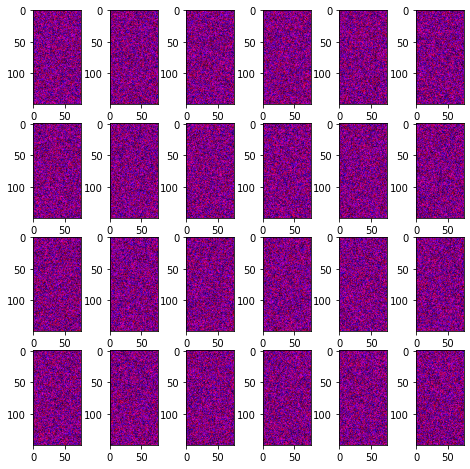

In [ ]:
model = create_fourier_model()
visualize_filters(model)

### After Training

In [12]:
import sklearn.model_selection
training_epochs=3
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
for _ in range(training_epochs):
  model.fit(to_gen(X_train, y_train, batch_size=32))
print("accuracy =", accuracy_for_model(model, X_test, y_test))

488/488 [==============================] - 10s 21ms/step - loss: 0.1982 - accuracy: 0.7152
accuracy = 0.6742217011853588


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


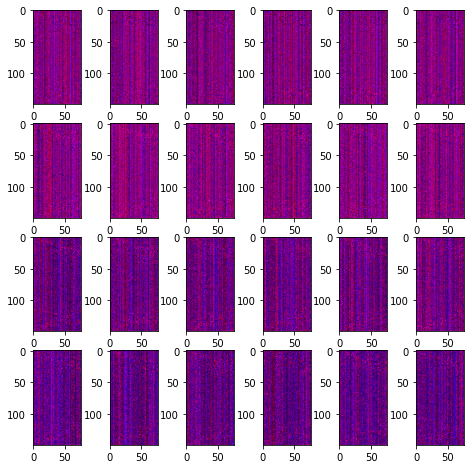

In [ ]:
visualize_filters(model)

## Kernel


### Before training

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


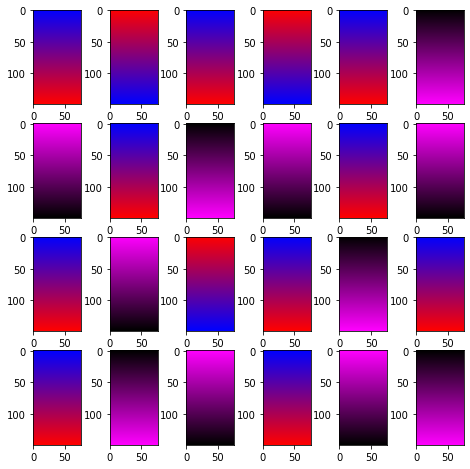

In [15]:
model = create_kernel_model()
visualize_filters(model)

### After Training

In [16]:
import sklearn.model_selection
training_epochs=3
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
for _ in range(training_epochs):
  model.fit(to_gen(X_train, y_train, batch_size=32), verbose=0)
print("accuracy =", accuracy_for_model(model, X_test, y_test))

accuracy = 0.6703139247101733


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


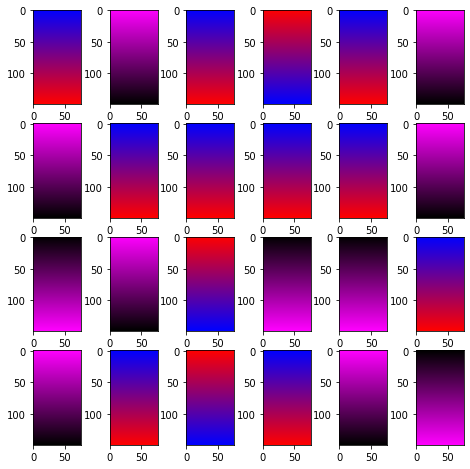

In [17]:
visualize_filters(model)

One thing I have noticed in the kernels fourier filters is that they have a few common recurring patterns